<a href="https://colab.research.google.com/github/Swastik200/30DaysOfDSA/blob/main/cnn2_rmse2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/CMAPSSData.zip" "/content"
!unzip CMAPSSData.zip

Archive:  CMAPSSData.zip
  inflating: CMAPSS/RUL_FD001.txt    
  inflating: CMAPSS/RUL_FD002.txt    
  inflating: CMAPSS/RUL_FD003.txt    
  inflating: CMAPSS/RUL_FD004.txt    
  inflating: CMAPSS/test_FD001.txt   
  inflating: CMAPSS/test_FD002.txt   
  inflating: CMAPSS/test_FD003.txt   
  inflating: CMAPSS/test_FD004.txt   
  inflating: CMAPSS/train_FD001.txt  
  inflating: CMAPSS/train_FD002.txt  
  inflating: CMAPSS/train_FD003.txt  
  inflating: CMAPSS/train_FD004.txt  
  inflating: CMAPSS/x.txt            


In [4]:
import random
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Flatten
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [108]:
setNumber = 1

In [109]:
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
rul_col = ['RUL']
all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

In [110]:
dataPath = '/content/CMAPSS/'


In [111]:
# This section is to load data
def loadData(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([26, 27], axis = 1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols +sensor_cols
    return data

In [112]:
# load train RUL also returns the max cycle, and this max cycle is also the life cylce
def addTrainRul(data, decrease_threshold=None):
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles

# use this last one only, return the data as well as the max life cycles
def loadTrainData(setNumber, decrease_threshold=None):
    fileName = dataPath + '/train_FD00' + str(setNumber) + '.txt'
    data = loadData(fileName)
    lifeCycles = addTrainRul(data, decrease_threshold)
    return data, lifeCycles

In [113]:
decrease_threshold = None
train, trainLifeCycles = loadTrainData(setNumber, decrease_threshold)

In [114]:
def loadTestRul(fileName):
    data = pd.read_csv(fileName, sep = " ", header=None)
    data.drop([1], axis=1, inplace=True)
    data.columns = ['RUL']
    return data
def addTestRul(data, rulData, decrease_threshold=None):
    testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles
# Use this last one only => return data as well as the max life cycles for each machine
def loadTestData(setNumber, decrease_threshold=None):
    data = loadData(dataPath + '/test_FD00' +str(setNumber)+'.txt')
    rulData = loadTestRul(dataPath + '/RUL_FD00' + str(setNumber)+'.txt')
    lifeCycles = addTestRul(data, rulData, decrease_threshold)
    return data, lifeCycles

In [115]:
# Also make test RUL becomes piecewise
test, testLifeCycles = loadTestData(setNumber, decrease_threshold)

In [116]:
from matplotlib import pyplot as plt
import seaborn as sns

In [117]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20  (manual selection based on sensor trends)
def plotSensorDataOfId(data, mcId):
    plt.figure(figsize=(30, 20))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        plt.subplot(10, 3, i+1).set_title(sensor)
        ssdata = data[data['id']==mcId]
        plt.plot(ssdata['cycle'], ssdata[sensor])
    plt.tight_layout()

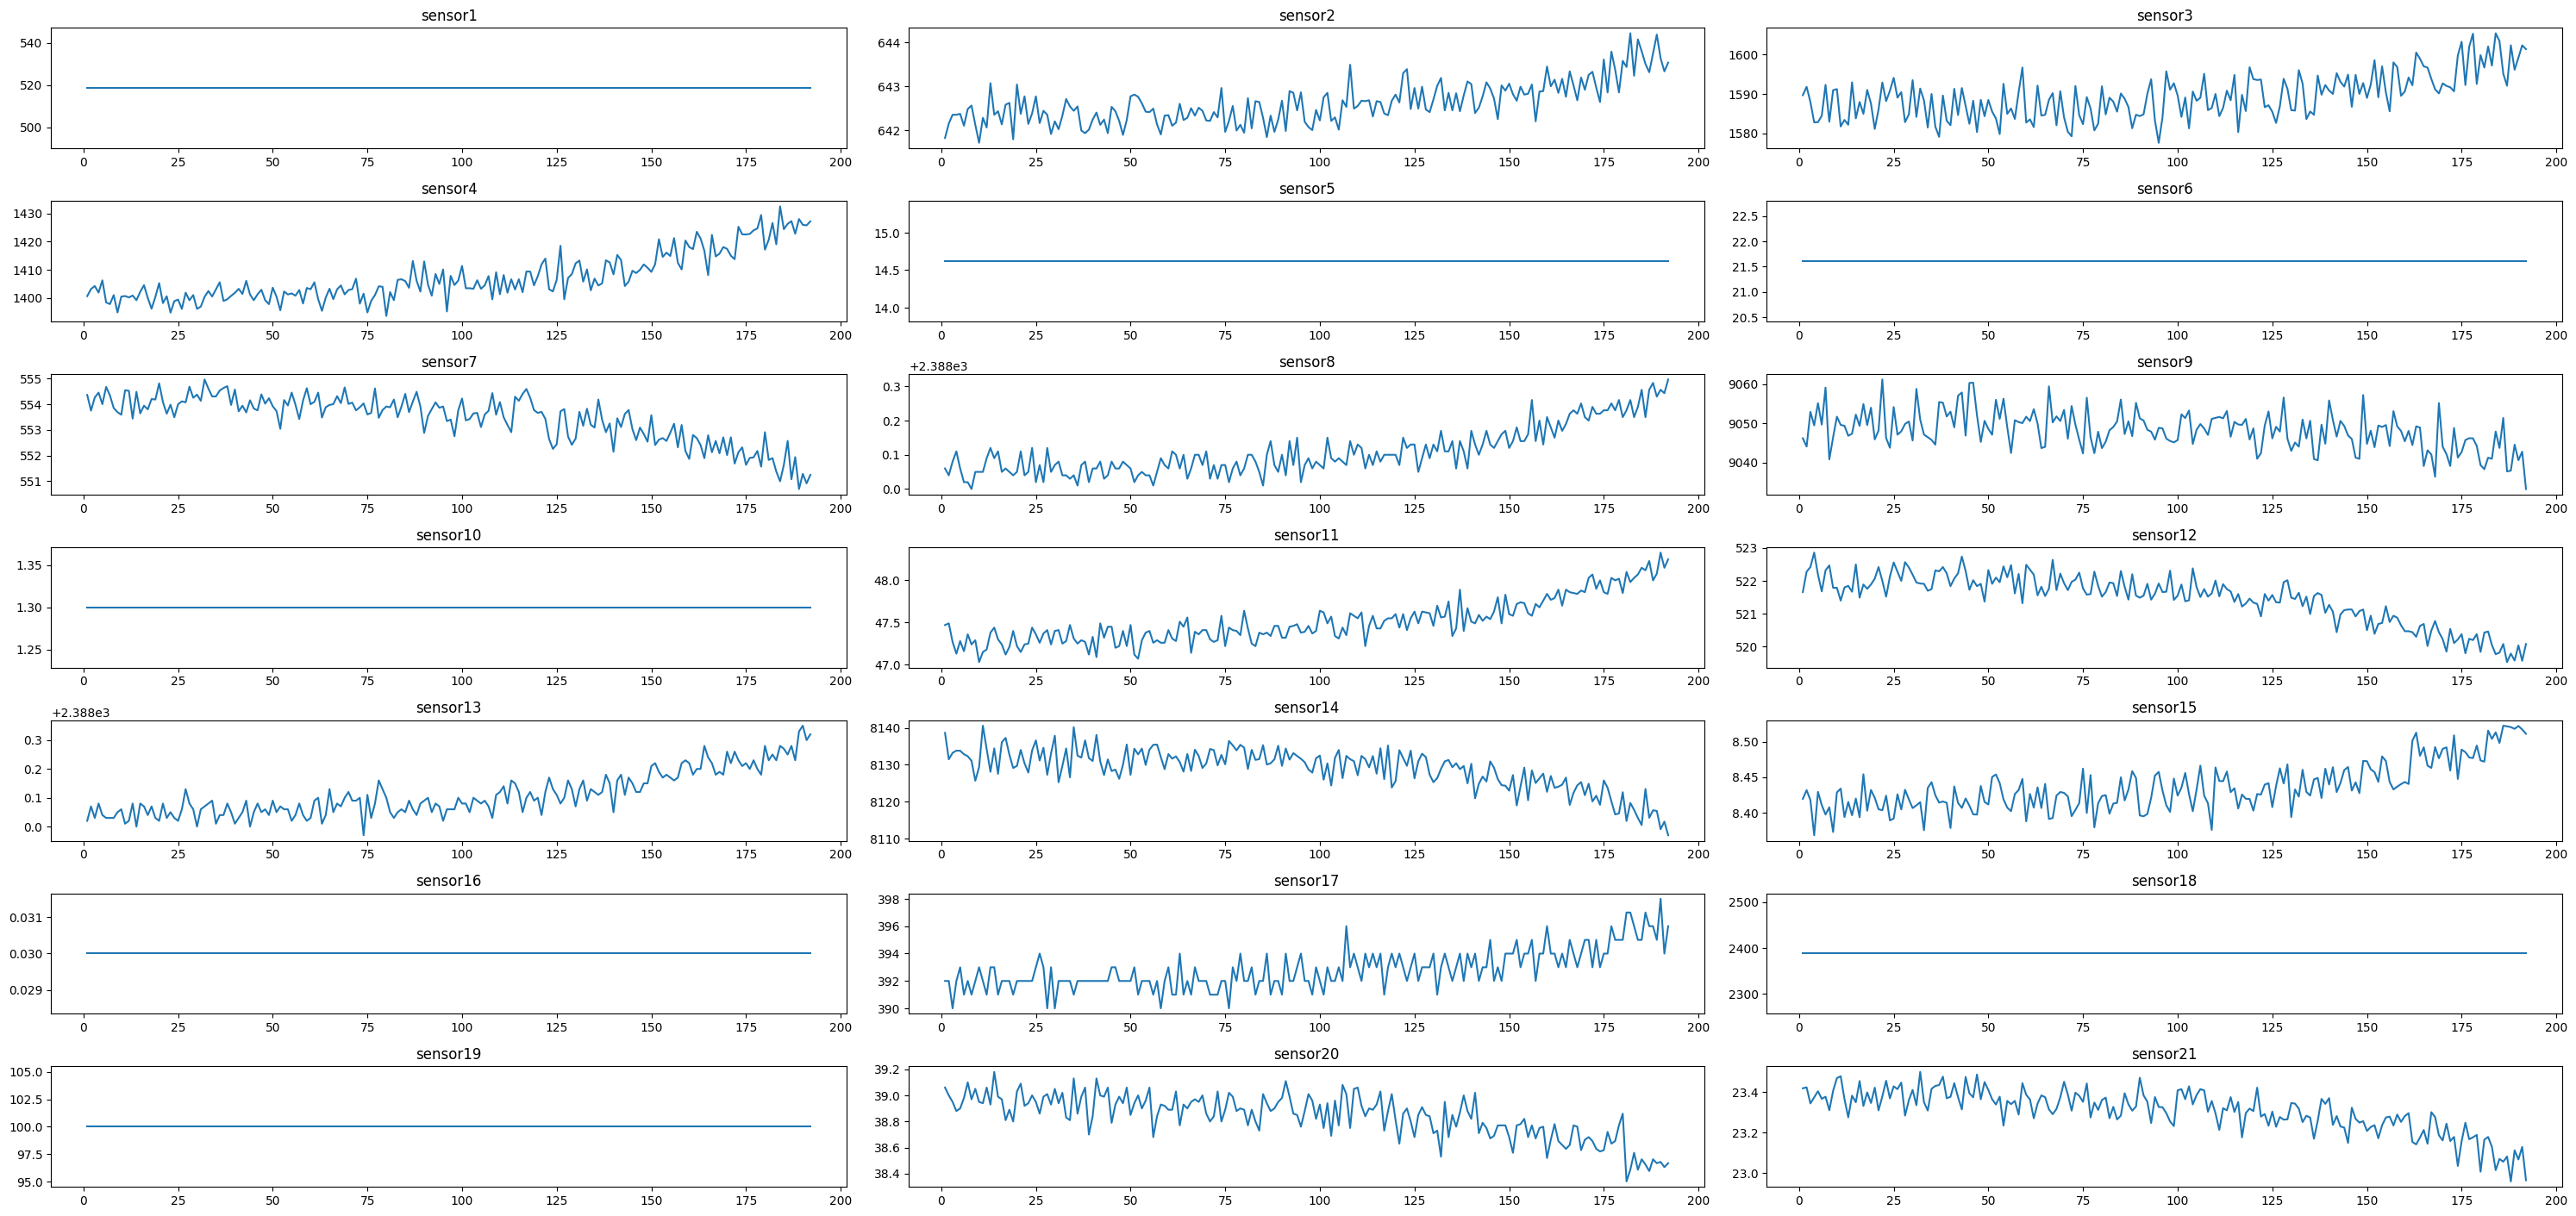

In [118]:
plotSensorDataOfId(train, 1)

In [119]:
def plotDataDistribution(data):
    sensors = []
    plt.figure(figsize=(30, 10))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        if(len(data[sensor].unique())>1):
            sensors.append(sensor)
            plt.subplot(3, 10, i+1)
            sns.distplot(data[sensor])
    plt.tight_layout()
    return sensors

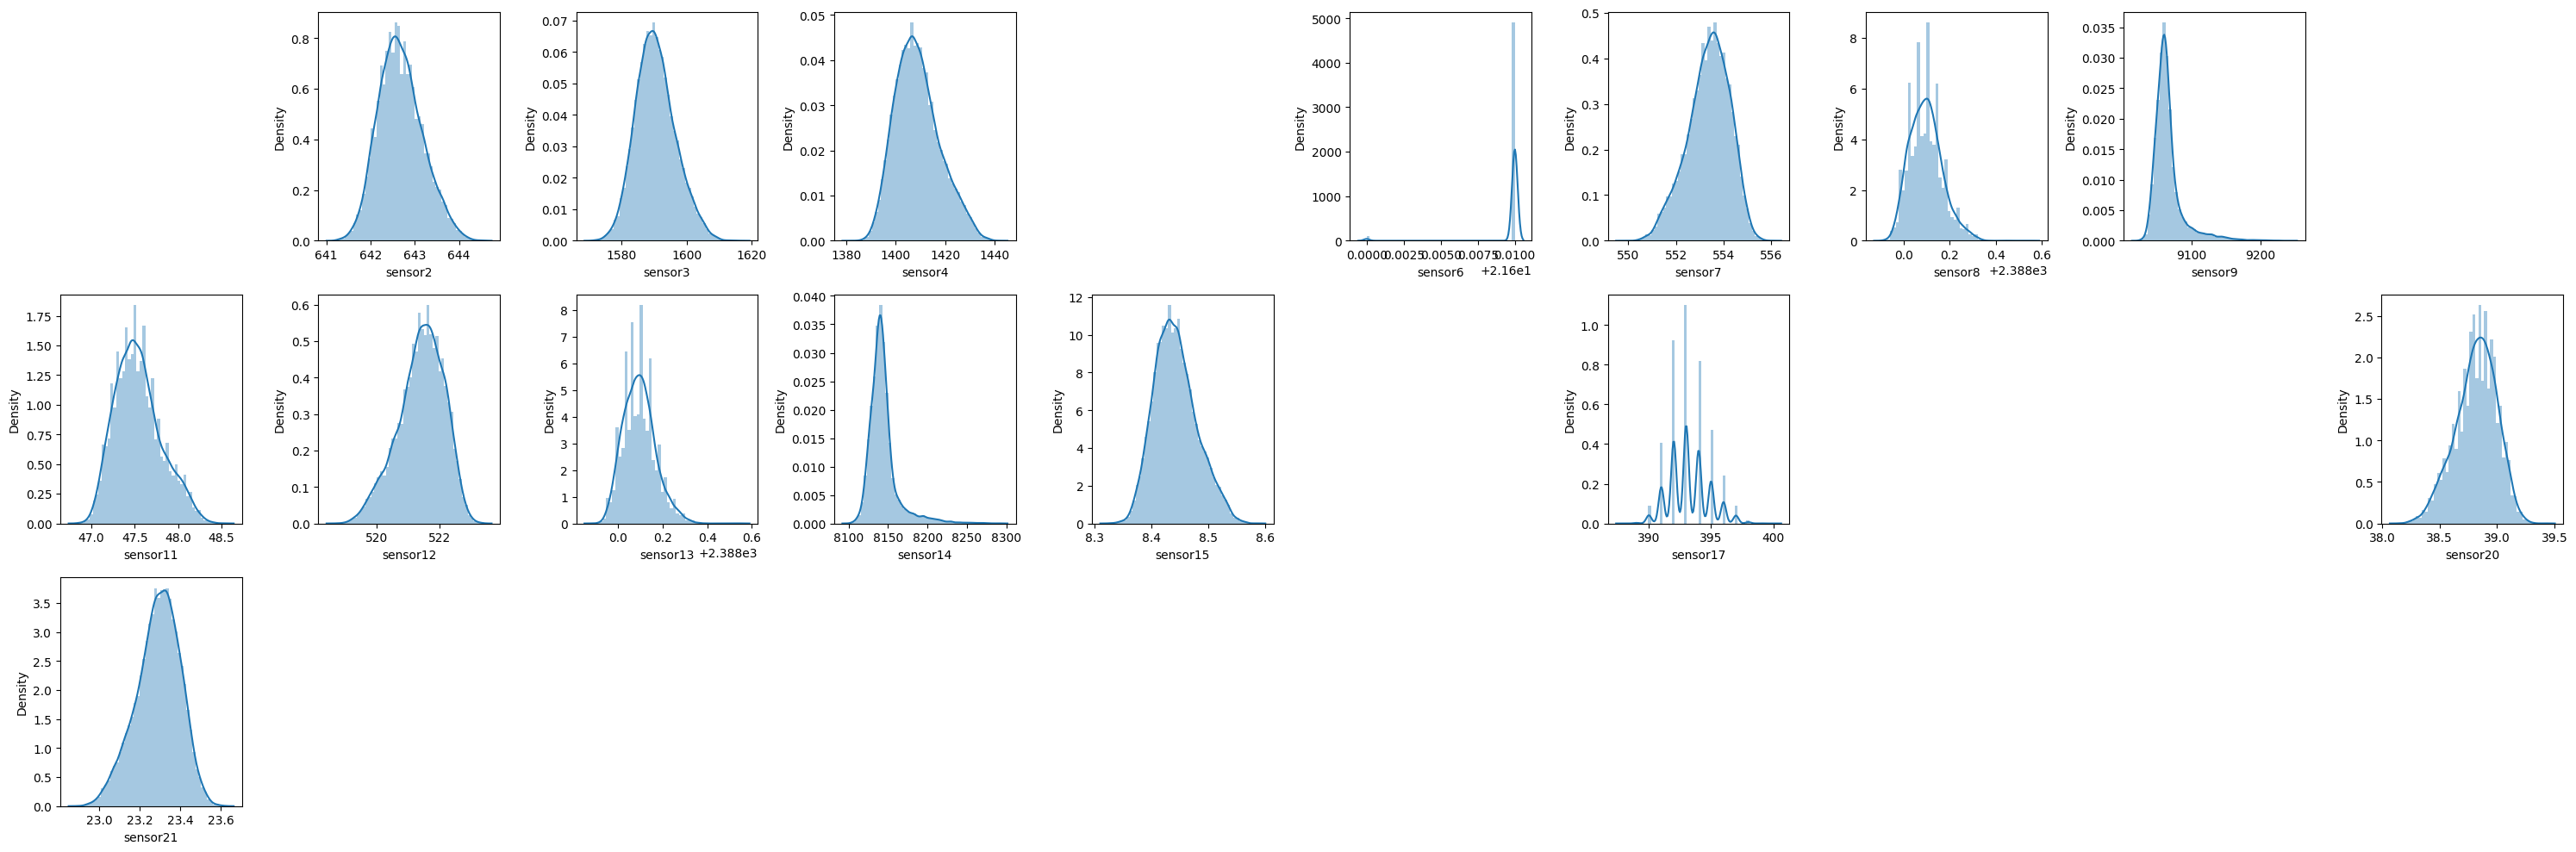

In [120]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20 => Why 16?
cols = plotDataDistribution(train)

In [121]:
def plotCorrelation(data):
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

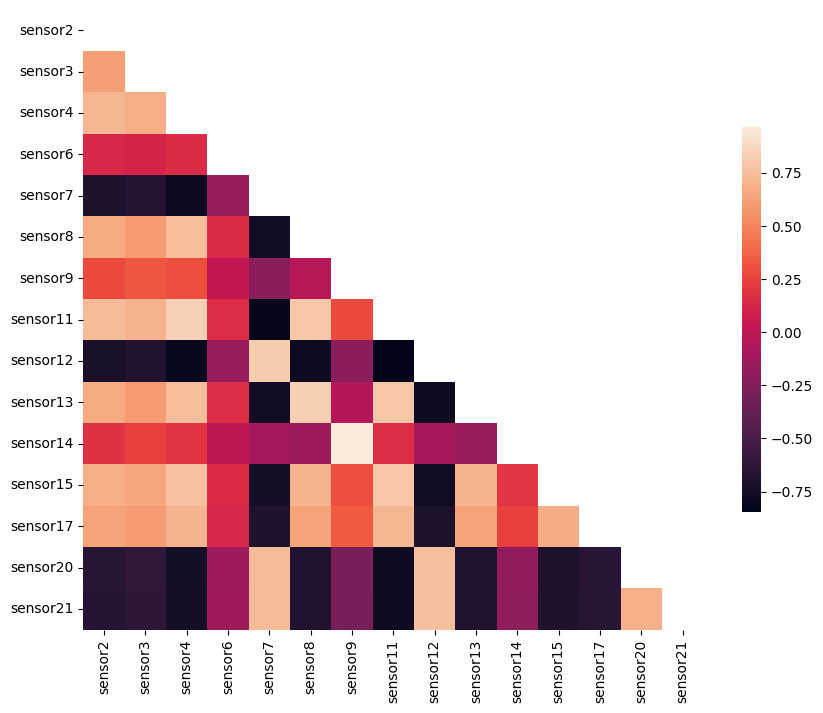

In [122]:
plotCorrelation(train[cols])

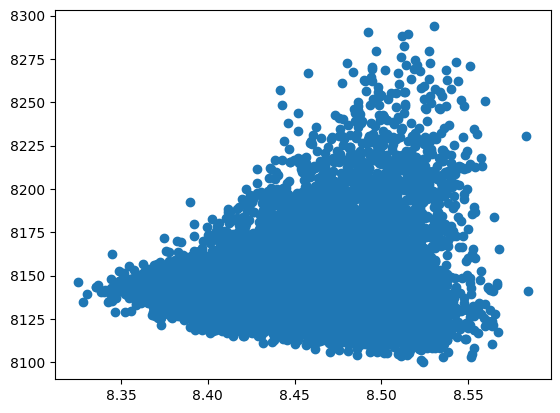

In [123]:
plt.scatter(train['sensor15'].values, train['sensor14'].values)

In [124]:
def plotCorrelationOfID(data, mcId):
    data1 = data[data['id']==mcId]
    data1 = data1.drop(['id'], axis = 1)
    corr = data1.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data1.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [126]:
# Scale the data and return the scaled data in form of a df and the scaler (will generate the scaler if doesn't pass it)
def scaleData(data, scaler=None):
    scaled_fields = setting_cols+sensor_cols
    if scaler == None:
        scaler = StandardScaler().fit(data[scaled_fields].values)
#         scaler = MinMaxScaler().fit(data[scaled_fields].values)
    scaled_data = scaler.transform(data[scaled_fields].values)
    scaled_df0 = pd.DataFrame(scaled_data)
    scaled_df0.columns = scaled_fields
    scaled_df1 = data.copy()
    for i in range(len(scaled_fields)):
        theField = scaled_fields[i]
        scaled_df1[theField] = scaled_df0[theField]
    return scaled_df1, scaler

In [127]:
# Scaled train
scaled_train, scaler = scaleData(train)
# Scaled test
scaled_test, scaler = scaleData(test, scaler)

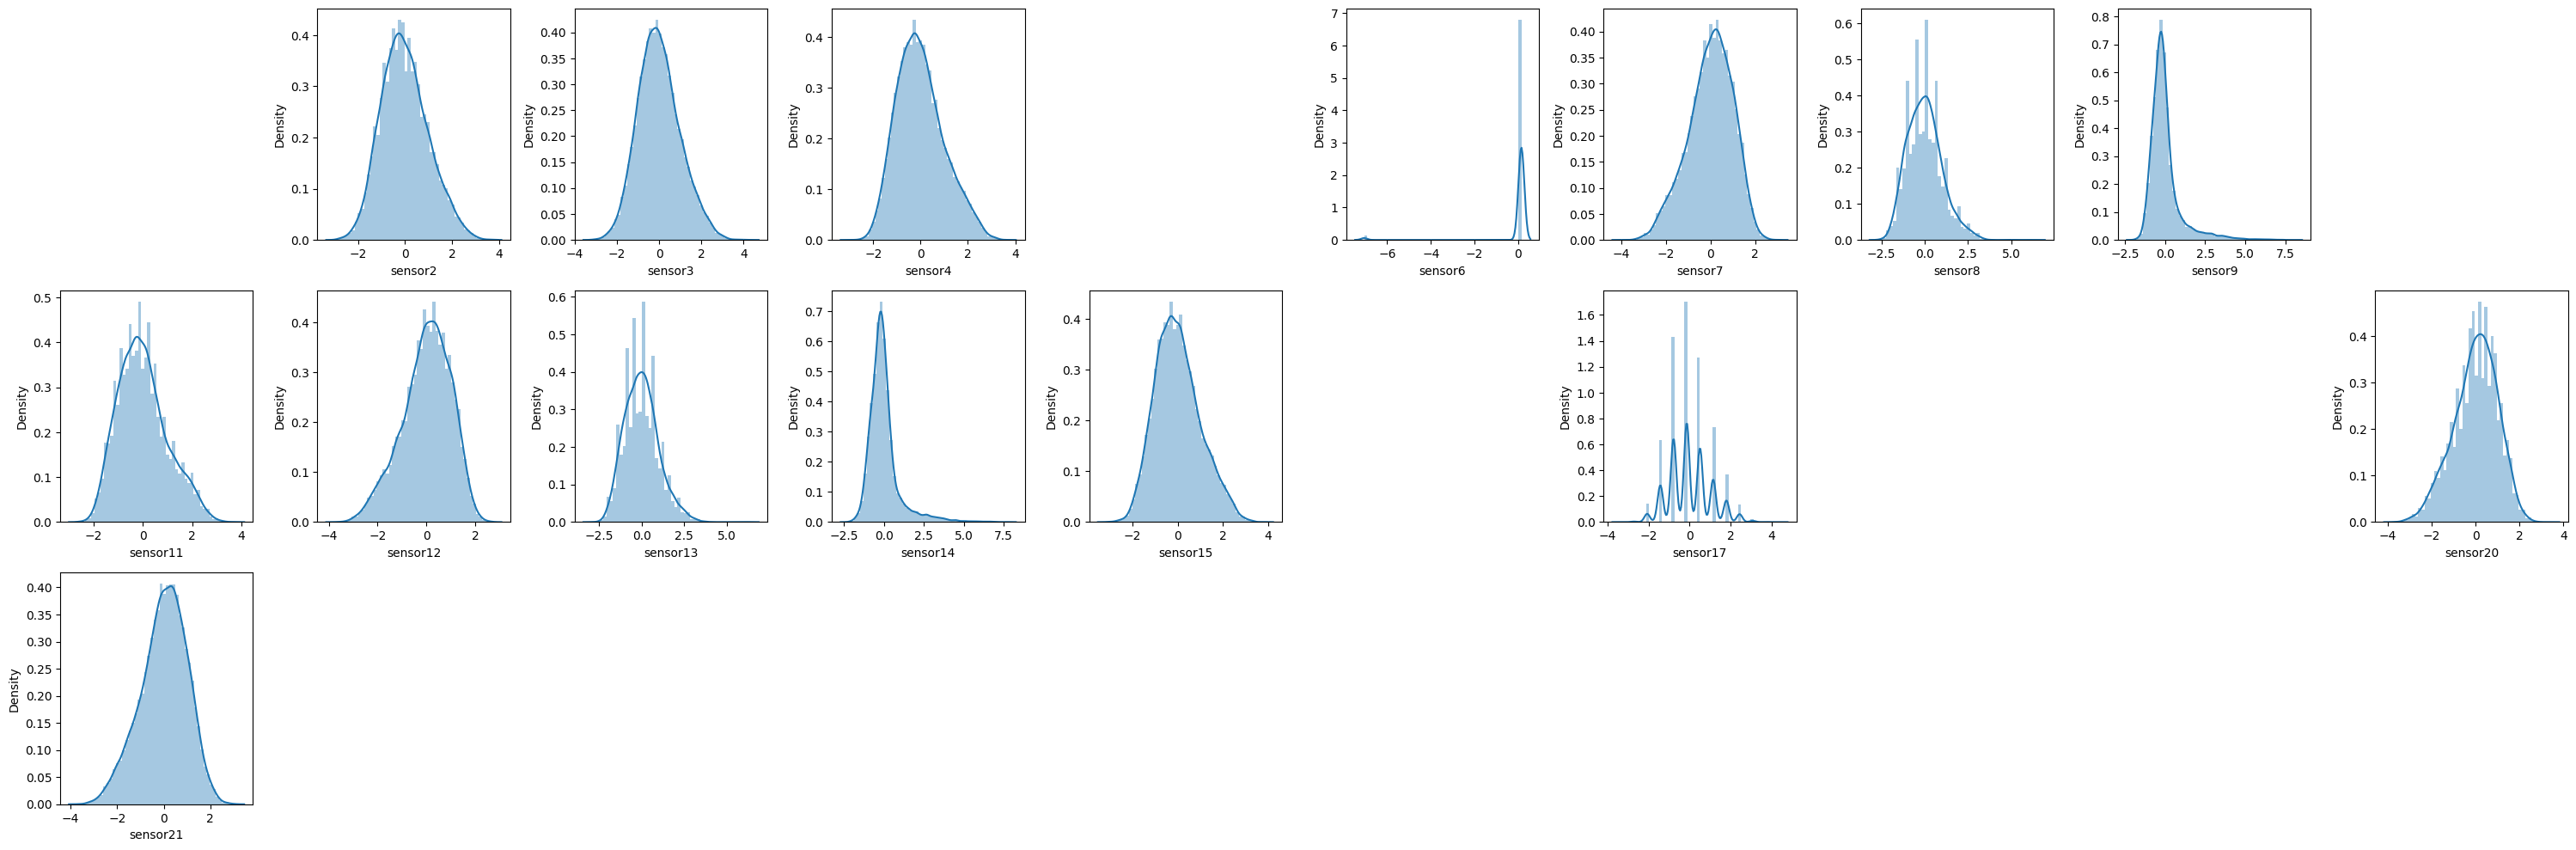

In [128]:
# plot to make sure that the scaled data still keep its shape.
cols = plotDataDistribution(scaled_train)

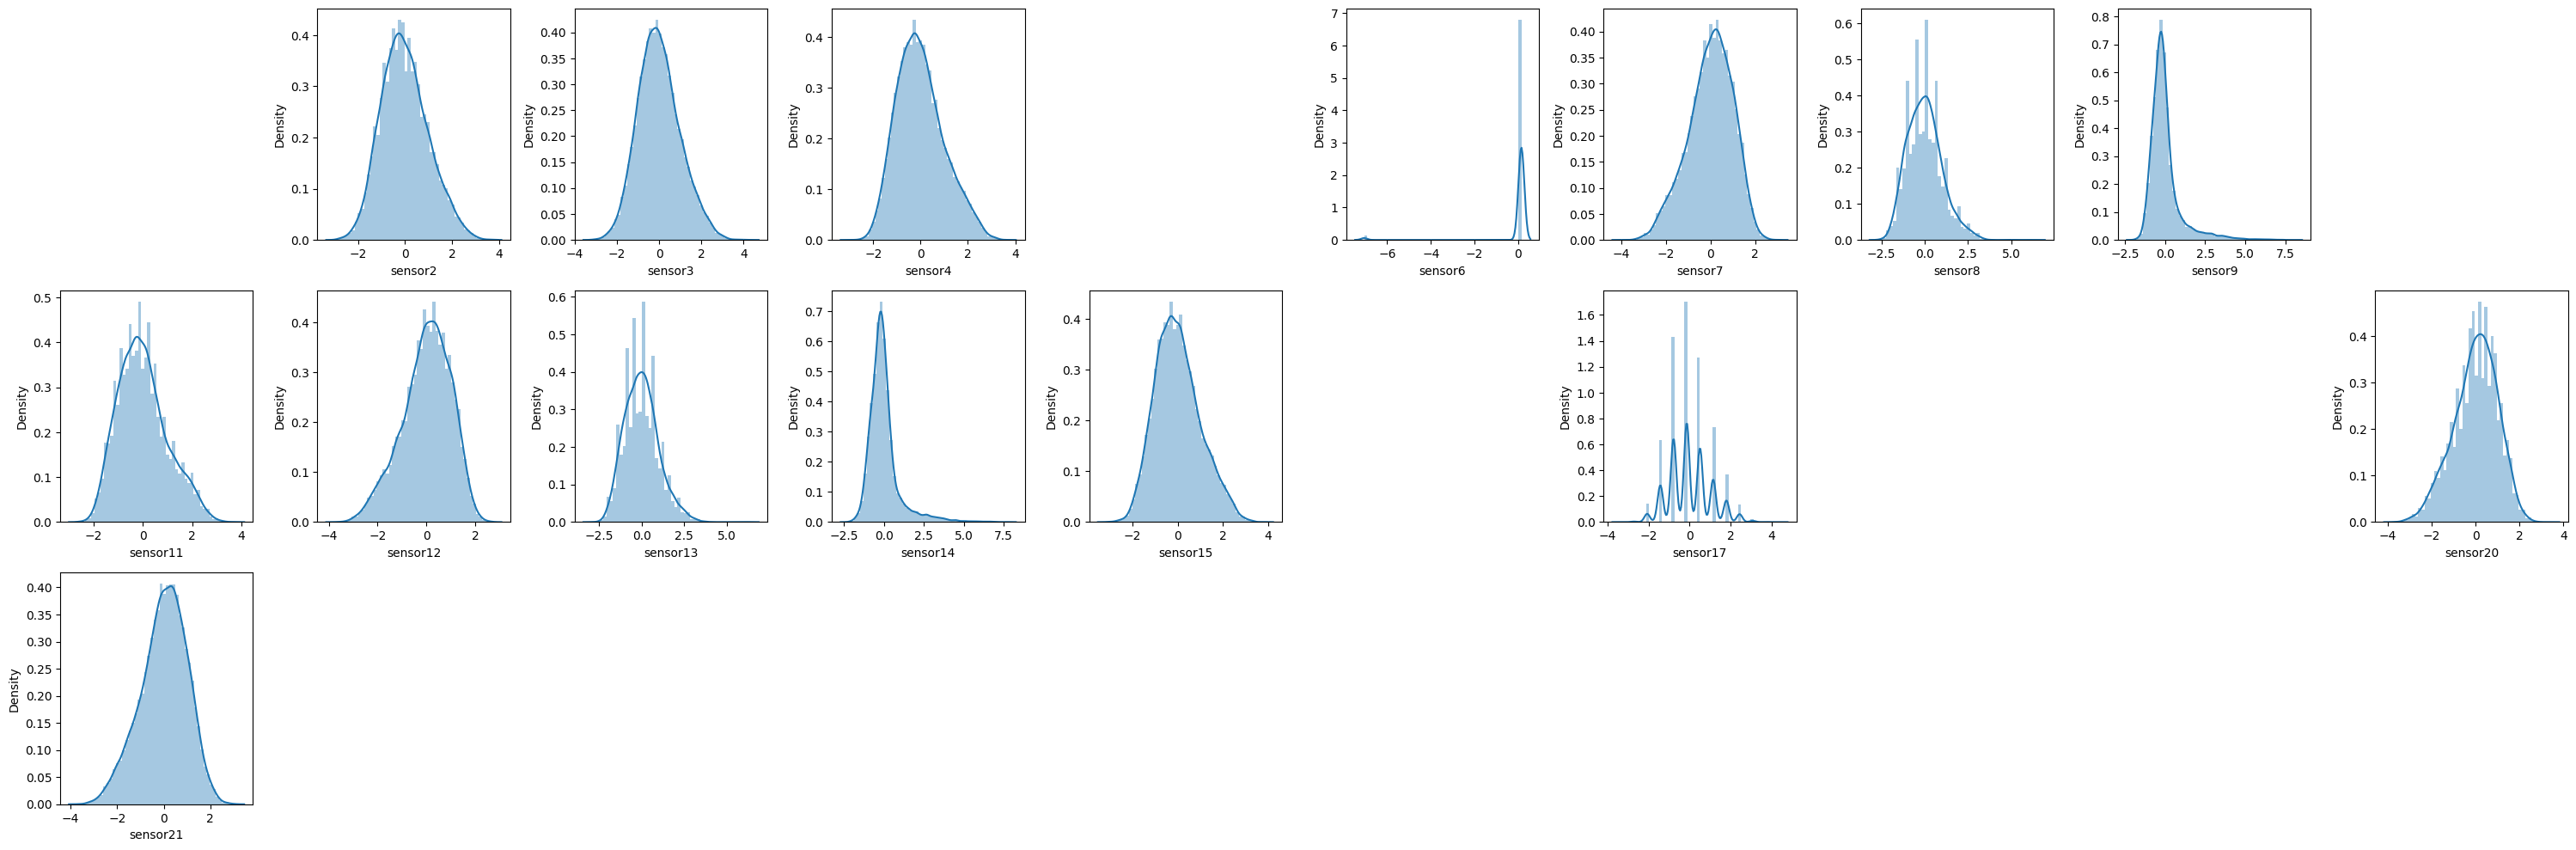

In [129]:
# plot to make sure that the scaled data still keep its shape.
cols = plotDataDistribution(scaled_train)

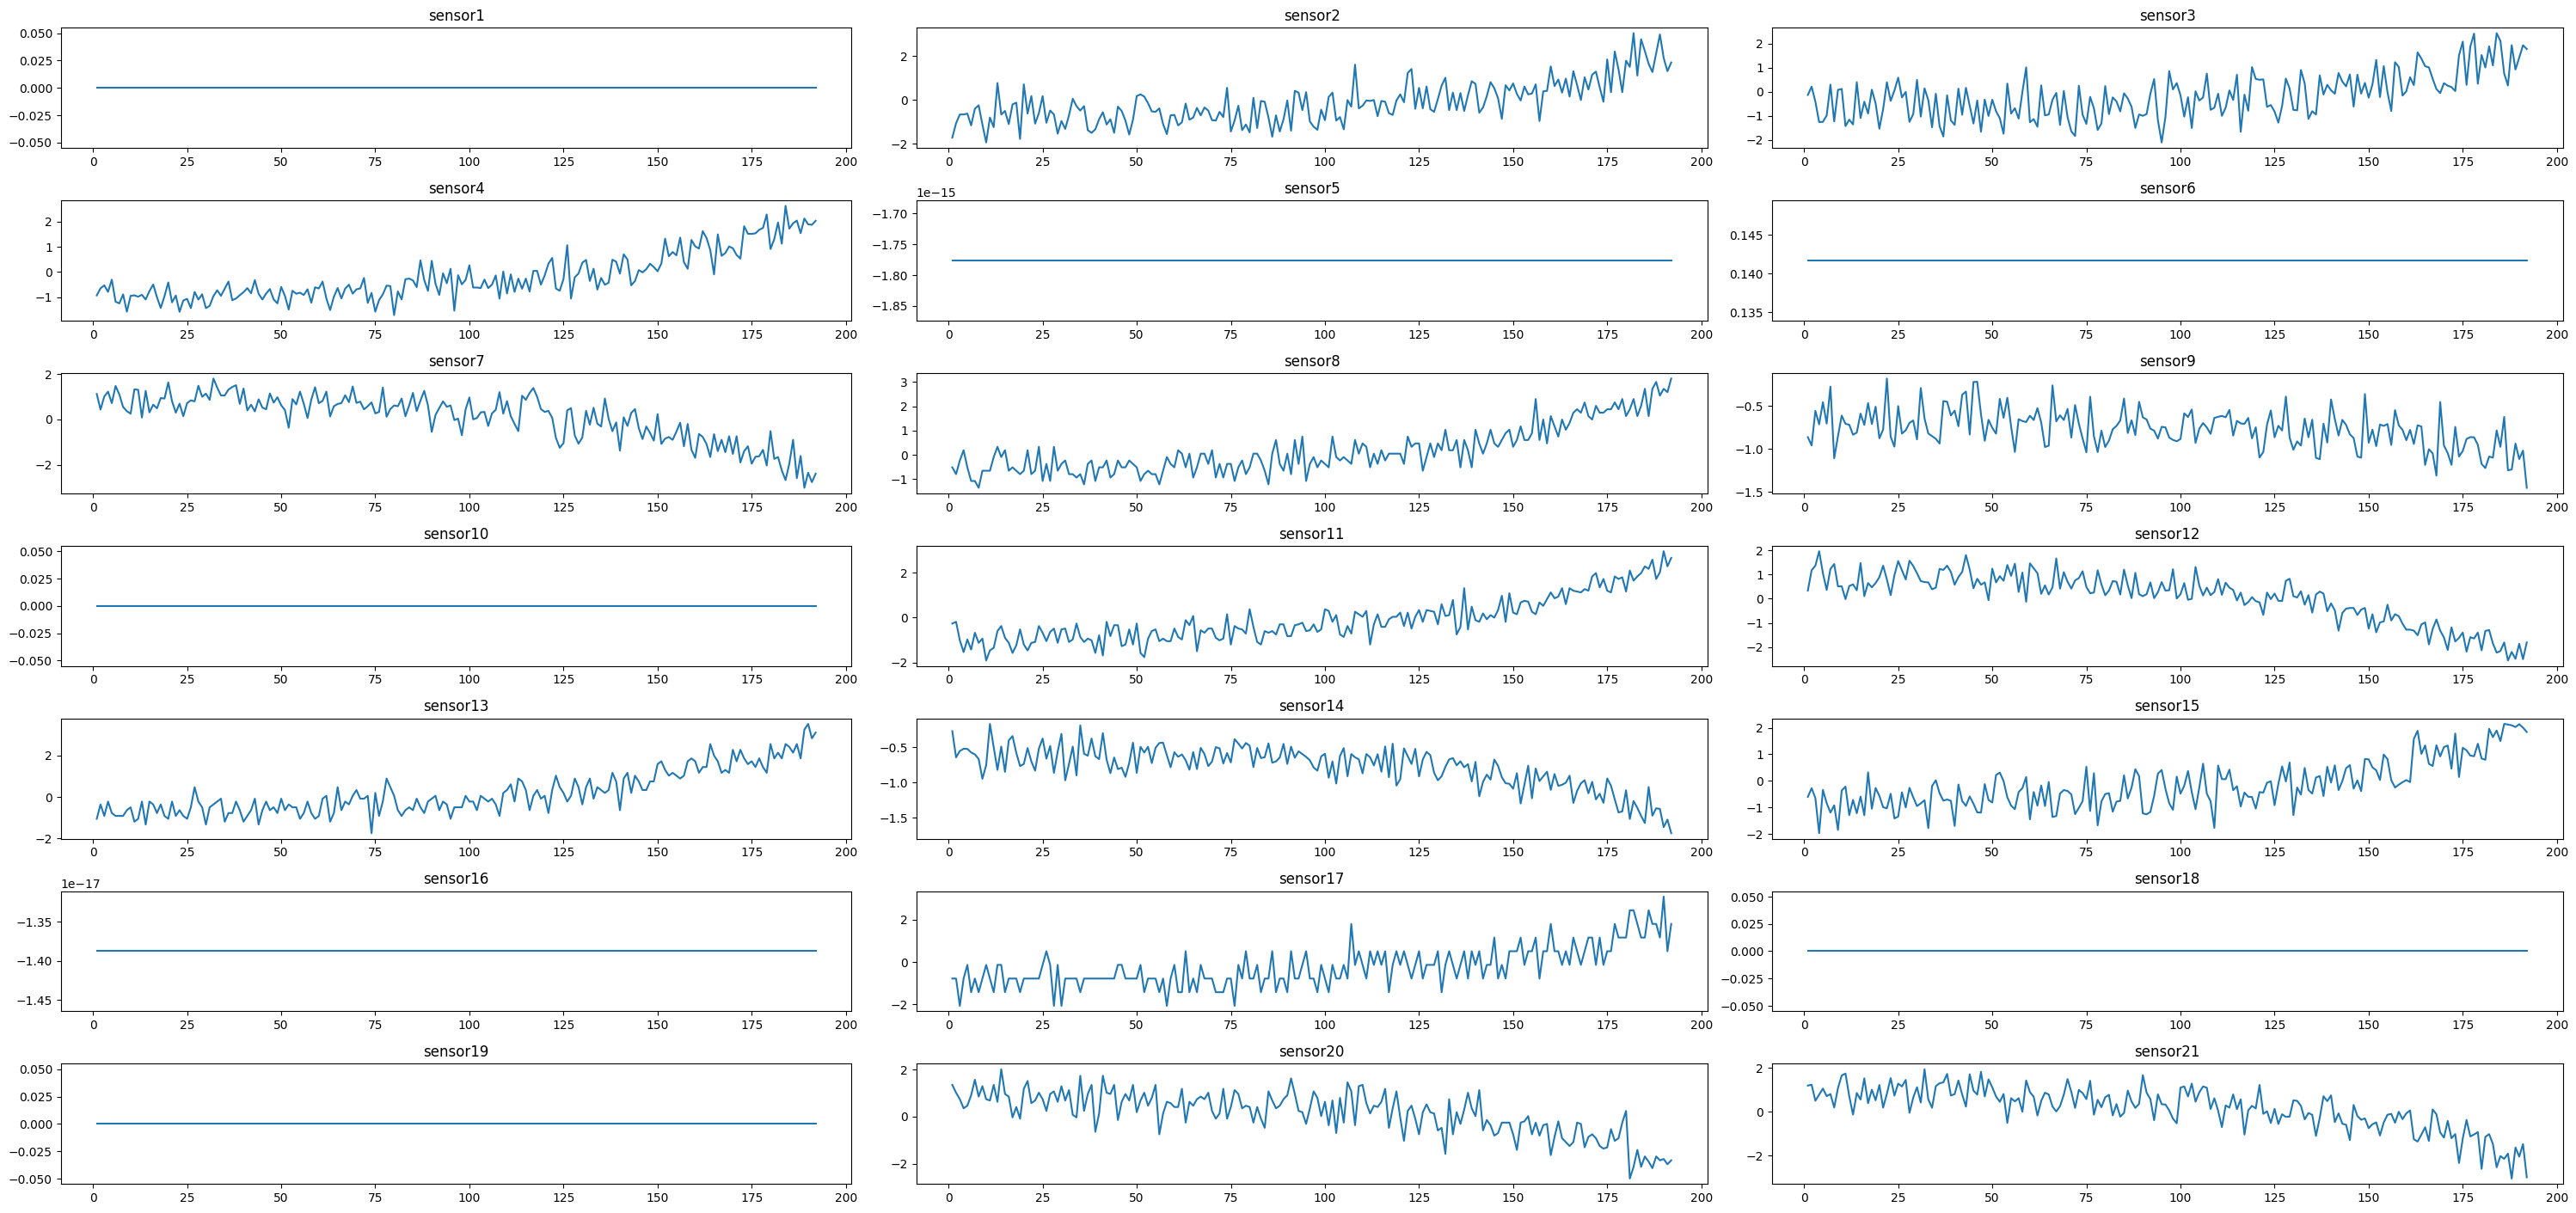

In [130]:
plotSensorDataOfId(scaled_train, 1)

In [132]:
import random
def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['id'].unique()
    if movingAverage==None:
        result = [data[data['id']==mId].values for mId in uniqueIds]
    else:
        result = [data[data['id']==mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
    maxlen = np.max([len(x) for x in result])
    #Augment the data now
    if(augmentStartCycle!=None and augmentEndCycle!= None):
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(50):
                idx = random.randint(max([maxCycle-145, 10]), max([maxCycle-10, 10]))
                if(len(mc[:idx, :])>0):
                    result1.append(mc[:idx, :])
            #Also add the complete sequence.
#             result1.append(mc)
        result = result1
    # calculate the ruls (-1) is the last column for RUL
    ruls = [min(mc[:, -1]) for mc in result]
    return result,ruls, maxlen
# Use this last one only (prev one is a helper)
from keras.preprocessing.sequence import pad_sequences
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if(maxlen==None): maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

In [133]:
augmentStartCycle = 130
augmentEndCycle = 362
maxlen=200
movingAverage = None
padded_train, train_ruls, maxlen = getPaddedSequence(scaled_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(scaled_test, maxlen=maxlen, movingAverage=movingAverage)

<Axes: ylabel='Density'>

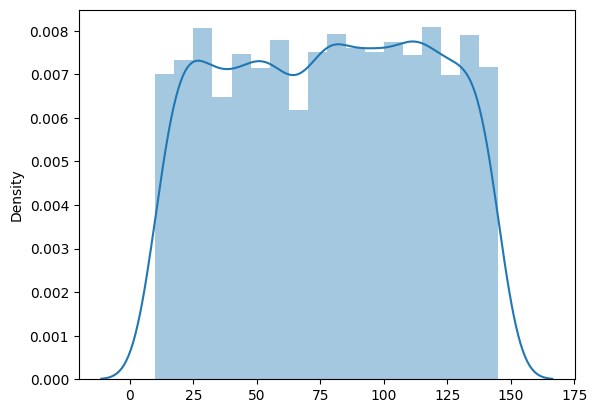

In [134]:
sns.distplot(train_ruls)

In [135]:
def plotDataForIndex(data, theIndex):
    plt.figure(figsize=(30, 30))
    for i in range(5, 26):
        plt.subplot(7, 3, i-4)
        values = data[theIndex][:, i]
        plt.plot(range(len(values)) ,values)
        plt.title('sensor'+str(i-4))
        plt.tight_layout()

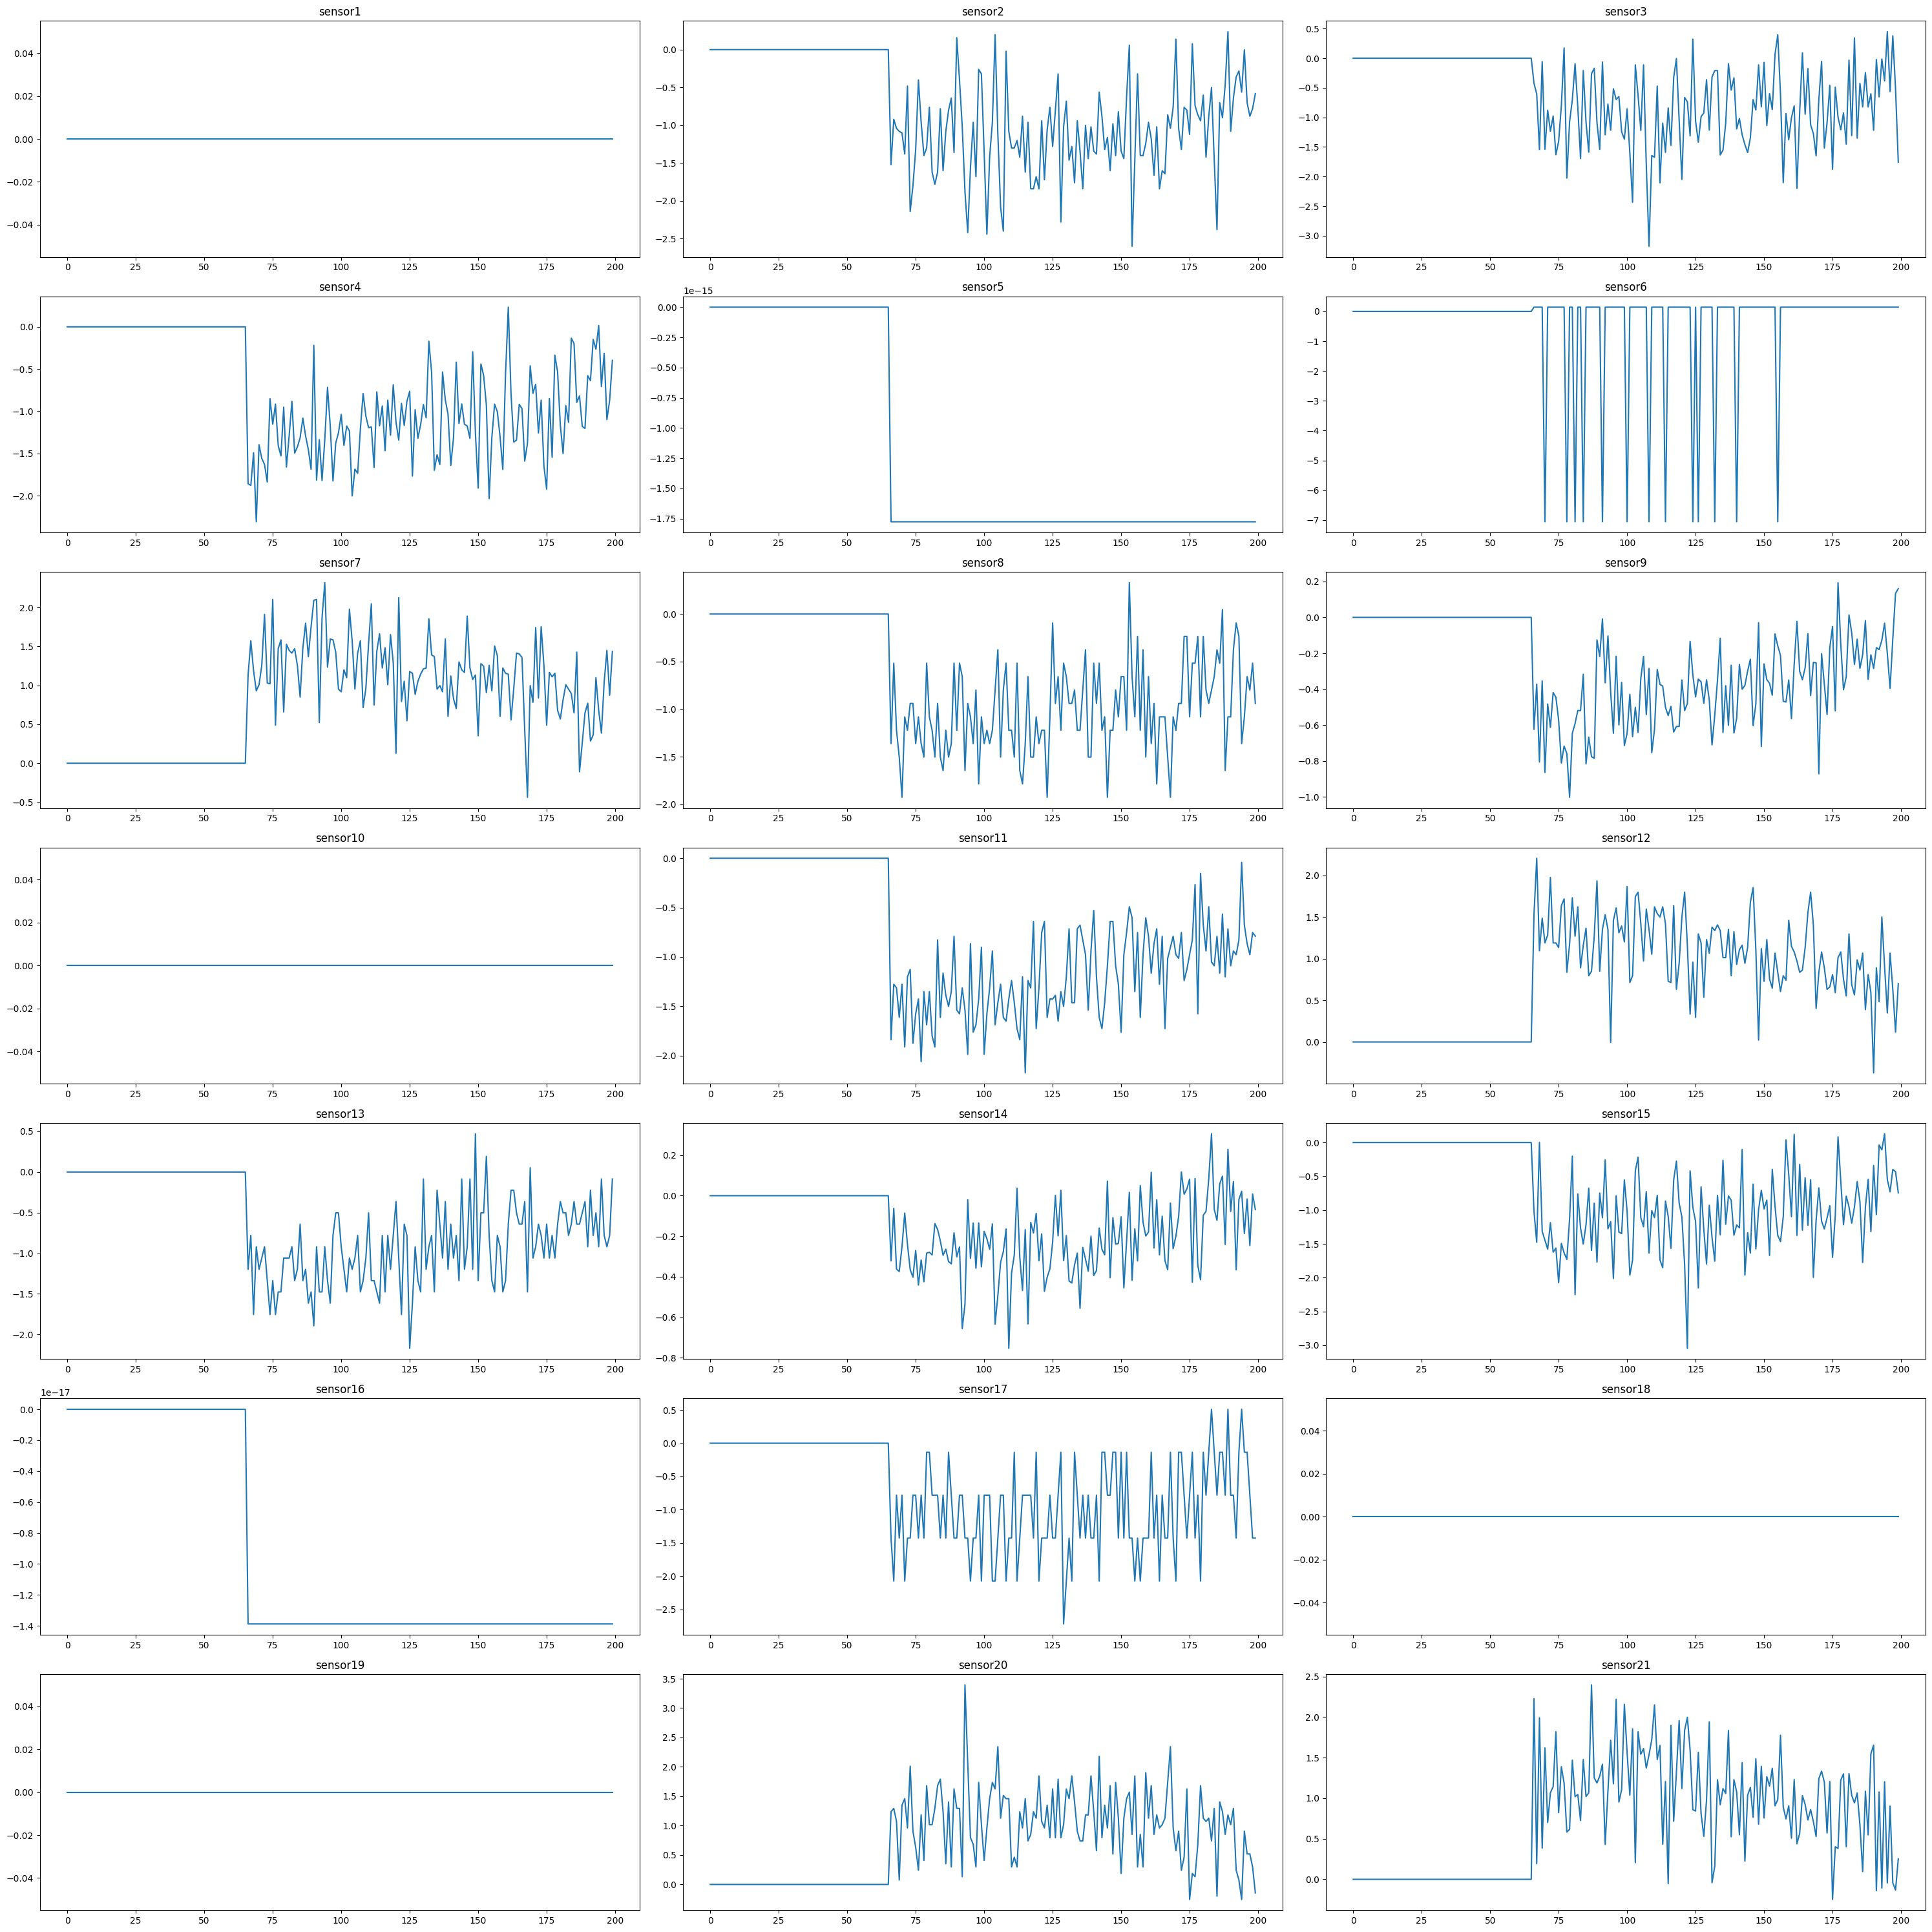

In [136]:
plotDataForIndex(padded_train, 450)

In [137]:
# selected_sensors = [7, 8, 9, 12, 16, 17, 20]
selected_sensors = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
# selected_sensors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
selected_sensors_indices = [x-1 for x in selected_sensors] # -1 because the index starts from 1

In [138]:
# X_train = padded_train[:, :, 5:26]
X_train = padded_train[:, :, 5:26][:, :, selected_sensors_indices]

In [139]:
# X_test = padded_test[:, :, 5:26]
X_test = padded_test[:, :, 5:26][:, :, selected_sensors_indices]

In [140]:
y_train = np.array(train_ruls).reshape(-1,1)
y_test = np.array(test_ruls).reshape(-1,1)

In [141]:
numOfSensors = len(X_train[0][0])

In [142]:
import codecs, json
def exportNPArrayToJSON(a, fileName):
    b = a.tolist() # nested lists with same data, indices
    json.dump(b, codecs.open(fileName, 'w', encoding='utf-8')) ### this saves the array in .json format

In [143]:
test_FD = 'test_FD00' + str(setNumber) + ".json"
train_FD = 'train_FD00' + str(setNumber) + ".json"
test_RUL_FD = 'test_RUL_FD00' + str(setNumber) + ".json"
train_RUL_FD = 'train_RUL_FD00' + str(setNumber) + ".json"
# exportNPArrayToJSON(X_train, train_FD)
exportNPArrayToJSON(X_test, test_FD)
# exportNPArrayToJSON(y_train, train_RUL_FD)
exportNPArrayToJSON(y_test, test_RUL_FD)

In [144]:
from IPython.display import FileLink

In [145]:
FileLink(test_FD)

/content/test_FD001.json

In [146]:
FileLink(test_RUL_FD)

/content/test_RUL_FD001.json

In [147]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

# from keras import backend as K
# K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=36, inter_op_parallelism_threads=36)))


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    do1 = Dropout(0.2)

    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    do2 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do3 = Dropout(0.2)

    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    do4 = Dropout(0.2)

    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    # combine the layers
#     layers = [lstm1, do1, lstm2, do2, dense1, do3, dense2, do4, outL]
    layers = [lstm1, lstm2, do2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='mse')
    return model

In [148]:
model = createModel(64, 64, 64, 8, (maxlen, numOfSensors))

In [149]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 200, 64)           20480     
                                                                 
 lstm_42 (LSTM)              (None, 200, 64)           33024     
                                                                 
 dropout_50 (Dropout)        (None, 200, 64)           0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_36 (Dense)            (None, 64)                819264    
                                                                 
 dense_37 (Dense)            (None, 8)                 520       
                                                                 
 dense_38 (Dense)            (None, 1)               

In [150]:
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

In [151]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, Add
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os


In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional

def createCNNLSTMModel(inputShape):
    cv1 = Conv1D(filters=18, kernel_size=2, strides=1, padding='same', activation='relu', name='cv1', input_shape=inputShape)
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp1')

    cv2 = Conv1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2')
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp2')

    cv3 = Conv1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3')
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp3')

    lstm5 = LSTM(units=inputShape[1] * 3, return_sequences=True)
    do5 = Dropout(0.2)

    lstm6 = LSTM(units=inputShape[1] * 3, return_sequences=True)
    do6 = Dropout(0.2)

    bilstm7 = Bidirectional(LSTM(units=64, return_sequences=True))
    bilstm_do1 = Dropout(0.2)

    bilstm8 = Bidirectional(LSTM(units=64))
    do8 = Dropout(0.2)

    d9 = Dense(units=50, activation='relu')
    do9 = Dropout(0.2)

    dout = Dense(units=1)

    model = Sequential([cv1, mp1, cv2, mp2, cv3, mp3, lstm5, do5, lstm6, do6, bilstm7, bilstm_do1, bilstm8, do8, d9, do9, dout])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['RootMeanSquaredError'])
    return model

# Example usage
inputShape = (30, 15)  # Example input shape
model = createCNNLSTMModel(inputShape)
model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cv1 (Conv1D)                (None, 30, 18)            558       
                                                                 
 mp1 (MaxPooling1D)          (None, 15, 18)            0         
                                                                 
 cv2 (Conv1D)                (None, 15, 36)            1332      
                                                                 
 mp2 (MaxPooling1D)          (None, 8, 36)             0         
                                                                 
 cv3 (Conv1D)                (None, 8, 72)             5256      
                                                                 
 mp3 (MaxPooling1D)          (None, 4, 72)             0         
                                                                 
 lstm_61 (LSTM)              (None, 4, 45)           

In [165]:
def createCNNLSTMModel(inputShape):
    cv1 = Convolution1D(input_shape=inputShape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu', name='cv1')
    bn1 = BatchNormalization(axis=-1)
    mp1 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp1')

    cv2 = Convolution1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu', name='cv2')
    bn2 = BatchNormalization(axis=-1)
    mp2 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp2')

    cv3 = Convolution1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu', name='cv3')
    bn3 = BatchNormalization(axis=-1)
    mp3 = MaxPooling1D(pool_size=2, strides=2, padding='same', name='mp3')

    d4 = Dense(inputShape[0] * inputShape[1], activation='relu')
    do4 = Dropout(0.2)

    lstm5 = LSTM(inputShape[1] * 3, return_sequences=True)
    do5 = Dropout(0.2)

    lstm6 = LSTM(inputShape[1] * 3)
    do6 = Dropout(0.2)

    bilstm7 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
    bilstm_do1 = tf.keras.layers.Dropout(0.2)
    bilstm8 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))

    d7 = Dense(50, activation='relu')
    do7 = Dropout(0.2)

    dout = Dense(1)

    model = Sequential([cv1, bn1, mp1, cv2, bn2, mp2, cv3, bn3, mp3, bilstm7, bilstm_do1, bilstm8, d7, do7, dout])
    model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Display model summary table
    print("CNN-LSTM Model Summary:")
    model.summary()

    return model

# Example usage
inputShape = (30, 15)  # Example input shape
model = createCNNLSTMModel(inputShape)


CNN-LSTM Model Summary:
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cv1 (Conv1D)                (None, 30, 18)            558       
                                                                 
 batch_normalization_18 (Ba  (None, 30, 18)            72        
 tchNormalization)                                               
                                                                 
 mp1 (MaxPooling1D)          (None, 15, 18)            0         
                                                                 
 cv2 (Conv1D)                (None, 15, 36)            1332      
                                                                 
 batch_normalization_19 (Ba  (None, 15, 36)            144       
 tchNormalization)                                               
                                                                 
 mp2 (MaxPooling1D)          

Processed train data shape:  (17456, 30, 15)
Processed validation data shape:  (4364, 30, 15)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)
